In [57]:
import requests
import json
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel
from typing import List, Dict, Any
from langchain_core.prompts import ChatPromptTemplate
# Download HTML content for each relevant result and convert to markdown
import os
import pathlib
from bs4 import BeautifulSoup
import re

from bs4 import BeautifulSoup
import re


search_terms = ["Agentic AI", "OpenAI Twitter"]

class ResultRelevance(BaseModel):
    explanation: str
    id: str

class RelevanceCheckOutput(BaseModel):
    relevant_results: List[ResultRelevance]

def search_serper(search_query):
    url = "https://google.serper.dev/search"
    
    payload = json.dumps({
        "q": search_query,
        "gl": "gb", 
        "num": 30,
        "tbs": "qdr:d"
    })

    headers = {
        'X-API-KEY': '2cfb0efb4ce760a4061a4234229967b41207dff5',
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    results = json.loads(response.text)
    results_list = results['organic']
    # Item structure:
    #   title:
    #     Value type: str
    #   link:
    #     Value type: str
    #   snippet:
    #     Value type: str
    #   date:
    #     Value type: str
    #   position:
    #     Value type: int
    # Filter down to only title, link and snippet
    all_results = []
    for id, result in enumerate(results_list, 1):
        result_dict = {
            'title': result['title'],
            'link': result['link'],
            'snippet': result['snippet'],
            'search_term': search_query,
            'id': id
        }
        all_results.append(result_dict)
    return all_results


# Read and parse .env file manually
with open('.env', 'r') as f:
    for line in f:
        if line.strip():
            key, value = line.strip().split('=', 1)
            os.environ[key] = value

def load_prompt(prompt_name):
    with open(f"prompts/{prompt_name}.md", "r") as file:
        return file.read()


def check_search_relevance(search_results: Dict[str, Any]) -> RelevanceCheckOutput:
    """
    Analyze search results and determine the most relevant ones.
    
    Args:
        search_results: Dictionary containing search results to analyze
        
    Returns:
        RelevanceCheckOutput containing the most relevant results and explanation
    """
    prompt = load_prompt("relevance_check")
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", prompt)
    ])

    llm = ChatOpenAI(model="gpt-4o").with_structured_output(RelevanceCheckOutput)
    llm_chain = prompt_template | llm
    
    return llm_chain.invoke({'input_search_results': search_results})


def convert_html_to_markdown(html_content):
    # Create BeautifulSoup object
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Convert common HTML elements to markdown
    
    # Headers
    for h in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
        level = int(h.name[1])
        h.replace_with('#' * level + ' ' + h.get_text() + '\n\n')
    
    # Links
    for a in soup.find_all('a'):
        href = a.get('href', '')
        text = a.get_text()
        if href and text:
            a.replace_with(f'[{text}]({href})')
    
    # Bold
    for b in soup.find_all(['b', 'strong']):
        b.replace_with(f'**{b.get_text()}**')
    
    # Italic
    for i in soup.find_all(['i', 'em']):
        i.replace_with(f'*{i.get_text()}*')
    
    # Lists
    for ul in soup.find_all('ul'):
        for li in ul.find_all('li'):
            li.replace_with(f'- {li.get_text()}\n')
    
    for ol in soup.find_all('ol'):
        for i, li in enumerate(ol.find_all('li'), 1):
            li.replace_with(f'{i}. {li.get_text()}\n')
    
    # Get text and clean up
    text = soup.get_text()
    
    # Remove excess whitespace/newlines
    text = re.sub(r'\n\s*\n', '\n\n', text)
    text = text.strip()
    
    return text

def scrape_and_save_markdown(relevant_results):
    """
    Scrapes HTML content from URLs in relevant_results and saves as markdown files.
    
    Args:
        relevant_results: List of dictionaries containing search results with URLs
        
    Returns:
        List of dictionaries containing markdown content and metadata
    """
    # Create scraped_html directory if it doesn't exist
    pathlib.Path("scraped_markdown").mkdir(exist_ok=True)

    markdown_contents = []
    for result in relevant_results:
        if 'link' in result:
            payload = {
                "api_key": "c0bFSYJ2aaJQGjz3E03iL8fFCXC6kIM6Da0QAq5I3z4vR4TzWVnDqBGAW60y33FqGRENnAo67ZS0jFlM9D", 
                "url": result['link'],
                "render_js": "true"
            }

            response = requests.get("https://scraping.narf.ai/api/v1/", params=payload)
            if response.status_code == 200:
                # Create filename from ID or URL if ID not available
                filename = f"{result.get('id', hash(result['link']))}.md"
                filepath = os.path.join("scraped_markdown", filename)
                
                # Convert HTML to markdown
                markdown_content = convert_html_to_markdown(response.content.decode())
                
                # Save markdown content to file
                with open(filepath, 'w', encoding='utf-8') as f:
                    f.write(markdown_content)
                
                markdown_contents.append({
                    'url': result['link'],
                    'filepath': filepath,
                    'markdown': markdown_content,
                    'title': result.get('title', ''),
                    'id': result.get('id', '')
                })
            else:
                print(f"Failed to fetch {result['link']}: Status code {response.status_code}")

    print(f"Successfully downloaded and saved {len(markdown_contents)} pages as markdown to scraped_markdown/")
    return markdown_contents

def generate_summaries(markdown_contents):
    """
    Generates summaries for markdown content using GPT-4.
    
    Args:
        markdown_contents: List of dictionaries containing markdown content and metadata
        
    Returns:
        List of dictionaries containing summaries and URLs
    """
    # Create markdown_summaries directory if it doesn't exist
    pathlib.Path("markdown_summaries").mkdir(exist_ok=True)

    # Load the summary prompt
    summary_prompt = load_prompt("summarise_markdown_page")

    # Create prompt template
    summary_template = ChatPromptTemplate.from_messages([
        ("system", summary_prompt)
    ])

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o")
    summary_chain = summary_template | llm

    # Generate and save summaries
    summaries = []
    for content in markdown_contents:
        try:
            # Generate summary, limiting to first 2000 words
            summary = summary_chain.invoke({
                'markdown_input': ' '.join(content['markdown'].split()[:2000])
            })
            
            # Create filename for summary
            summary_filename = f"summary_{content['id']}.md"
            summary_filepath = os.path.join("markdown_summaries", summary_filename)
            
            # Save summary to file
            with open(summary_filepath, 'w', encoding='utf-8') as f:
                f.write(summary.content)
            
            # Add to summaries list
            summaries.append({
                'markdown_summary': summary.content,
                'url': content['url']
            })
                
        except Exception as e:
            print(f"Failed to summarize {content['filepath']}: {str(e)}")

    print(f"Successfully generated summaries for {len(markdown_contents)} pages in markdown_summaries/")
    return summaries


relevant_results = []
for search_term in search_terms:
    python_results = search_serper(search_term)
    results = check_search_relevance(python_results)
    
    # Get the relevant result IDs from the LLM output
    relevant_ids = [r.id for r in results.relevant_results]
    
    # Filter original results to only include those with matching IDs
    filtered_results = [r for r in python_results if str(r['id']) in relevant_ids]
    
    relevant_results.extend(filtered_results)
  
markdown_contents = scrape_and_save_markdown(relevant_results)
summaries = generate_summaries(markdown_contents)


Successfully downloaded and saved 10 pages as markdown to scraped_markdown/
Successfully generated summaries for 10 pages in markdown_summaries/


In [82]:
from langchain_openai import ChatOpenAI
from pydantic import Field
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import HumanMessage, AIMessage



class State(TypedDict):
    messages: Annotated[list, add_messages]
    summaries: List[dict]
    approved: bool
    created_summaries: Annotated[List[dict], Field(description="The summaries that have been created by the summariser")]

class SummariserOutput(BaseModel):
    email_summary: str = Field(description="The summary email of the content")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

class ReviewerOutput(BaseModel):
    approved: bool = Field(description="Whether the summary is approved or not")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")


llm = ChatOpenAI(model="gpt-4o")


# SUMMARISER
# Load the email template
with open("email_template.md", "r") as f:
    email_template = f.read()

# Load the summariser prompt
summariser_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("summariser")),
    ("placeholder", "{messages}"),
])
    
llm_summariser = summariser_prompt | llm.with_structured_output(SummariserOutput)


# REVIEWER

reviewer_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("reviewer")),
    ("placeholder", "{messages}"),
])

llm_reviewer = reviewer_prompt | llm.with_structured_output(ReviewerOutput)

def summariser(state: State):
    summariser_output = llm_summariser.invoke({"messages": state["messages"], "list_of_summaries": state["summaries"], "input_template": email_template})
    new_messages = [AIMessage(content=summariser_output.email_summary), AIMessage(content=summariser_output.message)]
    return {"messages": new_messages, "created_summaries": [summariser_output.email_summary]}

def reviewer(state: State):
    # Convert AIMessages to HumanMessages and vice versa
    converted_messages = []
    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            converted_messages.append(HumanMessage(content=msg.content))
        elif isinstance(msg, HumanMessage):
            converted_messages.append(AIMessage(content=msg.content))
        else:
            converted_messages.append(msg)
    state["messages"] = converted_messages
    reviewer_output = llm_reviewer.invoke({"messages": state["messages"]})
    new_messages = [HumanMessage(content=reviewer_output.message)]
    return {"messages": new_messages, "approved": reviewer_output.approved}

def conditional_edge(state: State) -> Literal["summariser", END]:
    if state["approved"]:
        return END
    else:
        return "summariser"


# Create the graph

graph_builder = StateGraph(State)
graph_builder.add_node("summariser", summariser)
graph_builder.add_node("reviewer", reviewer)

graph_builder.add_edge(START, "summariser")
graph_builder.add_edge("summariser", "reviewer")
graph_builder.add_conditional_edges('reviewer', conditional_edge)

graph = graph_builder.compile()


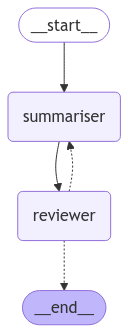

In [83]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)



In [84]:
output = graph.invoke({"summaries": summaries})

output

{'messages': [AIMessage(content="<html>\n<head>\n  <title>Big Company Updates</title>\n</head>\n<body>\n  <h1>Big Company Updates</h1>\n  <h2>Key Highlights</h2>\n  <ul>\n    <li><strong>Mainstream AI Adoption 🌐</strong>: Businesses are moving from AI pilots to comprehensive AI strategies. [Read More](https://www.raconteur.net/technology/2025-ai-trends)</li>\n    <li><strong>AI Agents' Risks and Benefits 🤖⚖️</strong>: AI agents improve efficiency but also pose risks like bias and privacy concerns. [Read More](https://www.weforum.org/stories/2024/12/ai-agents-risks-artificial-intelligence/)</li>\n    <li><strong>Q4 2024 Business Trends 📈</strong>: Discussions on tariffs and agentic AI rise, while sustainability talk declines. [Read More](https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks)</li>\n    <li><strong>Big Tech's AI Agent Investments 💼</strong>: Companies like Google and Microsoft invest heavily in AI agents. [Read More](https://medium.com/@mcunning

In [85]:
email_to_send = output["created_summaries"][-1]

In [86]:
email_to_send

'<html>\n<head>\n  <title>Big Company Updates</title>\n</head>\n<body>\n  <h1>Big Company Updates</h1>\n  <h2>Key Highlights</h2>\n  <ul>\n    <li><strong>Mainstream AI Adoption 🌐</strong>: Businesses are moving from AI pilots to comprehensive AI strategies. <a href="https://www.raconteur.net/technology/2025-ai-trends">Read More</a></li>\n    <li><strong>AI Agents\' Risks and Benefits 🤖⚖️</strong>: AI agents improve efficiency but also pose risks like bias and privacy concerns. <a href="https://www.weforum.org/stories/2024/12/ai-agents-risks-artificial-intelligence/">Read More</a></li>\n    <li><strong>Q4 2024 Business Trends 📈</strong>: Discussions on tariffs and agentic AI rise, while sustainability talk declines. <a href="https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks">Read More</a></li>\n    <li><strong>Big Tech\'s AI Agent Investments 💼</strong>: Companies like Google and Microsoft invest heavily in AI agents. <a href="https://medium.com/@mcunning

In [87]:
from __future__ import print_function
import sib_api_v3_sdk
from sib_api_v3_sdk.rest import ApiException

configuration = sib_api_v3_sdk.Configuration()
configuration.api_key['api-key'] = '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'

api_instance = sib_api_v3_sdk.TransactionalEmailsApi(sib_api_v3_sdk.ApiClient(configuration))
subject = "Daily AI Research Summary"
sender = {"name":"Will White","email":"whitew1994@gmail.com"}
replyTo = {"name":"Will White","email":"whitew1994@gmail.com"}
html_content = email_to_send
to = [{"email":"whitew1994@gmail.com","name":"Will White"}]
params = {"subject":"Daily AI Research Summary"}
send_smtp_email = sib_api_v3_sdk.SendSmtpEmail(to=to, reply_to=replyTo, html_content=html_content, sender=sender, subject=subject, params=params)

try:
    api_response = api_instance.send_transac_email(send_smtp_email)
    print(api_response)
except ApiException as e:
    print("Exception when calling SMTPApi->send_transac_email: %s\n" % e)

{'message_id': '<202412171100.18255337384@smtp-relay.mailin.fr>',
 'message_ids': None}
